# Univarate

In [2]:
import os
import argparse
import glob
from PIL import Image
import numpy as np
import matplotlib

# matplotlib.use('agg')
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch
import torch.nn as nn
import torch.optim as optim

parser = argparse.ArgumentParser()
parser.add_argument('--adjoint', action='store_true')
parser.add_argument('--viz', action='store_true')
parser.add_argument('--niters', type=int, default=1000)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--num_samples', type=int, default=512)
parser.add_argument('--width', type=int, default=64)
parser.add_argument('--hidden_dim', type=int, default=32)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--train_dir', type=str, default=None)
parser.add_argument('--results_dir', type=str, default="./results")
args = parser.parse_args('--results_dir=./Univarite --train_dir=./Univarite --niters=2000 --lr=1e-4 --viz'.split())
# args = parser.parse_args()

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


class CNF(nn.Module):
    """Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t)

            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)

            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()


class HyperNetwork(nn.Module):
    """Hyper-network allowing f(z(t), t) to change with time.

    Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


dir = r'D:\Python\torchdiffeq-master\examples\MultiTripleNorm.csv'
dir = r'D:\Python\torchdiffeq-master\examples\TripleNorm.csv'
data = np.loadtxt(dir).reshape([-1,1])
in_out_dim = 1

def get_batch(num_samples):
    # points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
    rand_row = np.random.choice(np.arange(data.shape[0]),num_samples)
    points = np.take(data, rand_row, axis=0)
    x = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)

    return (x, logp_diff_t1)


In [3]:
t0 = 0
t1 = 10
device = torch.device('cuda:' + str(args.gpu)
                      if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# model
func = CNF(in_out_dim=in_out_dim, hidden_dim=args.hidden_dim, width=args.width).to(device)
optimizer = optim.Adam(func.parameters(), lr=args.lr)
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
)
p_z0 = torch.distributions.Normal(
    loc=torch.tensor([0.0]).to(device),
    scale=torch.tensor([1]).to(device)
)
loss_meter = RunningAverageMeter()

if args.train_dir is not None:
    if not os.path.exists(args.train_dir):
        os.makedirs(args.train_dir)
    ckpt_path = os.path.join(args.train_dir, 'ckpt.pth')
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        func.load_state_dict(checkpoint['func_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print('Loaded ckpt from {}'.format(ckpt_path))

x, logp_diff_t1 = get_batch(args.num_samples)

z_t, logp_diff_t = odeint(
func,
(x, logp_diff_t1),
torch.tensor([t1, t0]).type(torch.float32).to(device),
atol=1e-5,
rtol=1e-5,
method='dopri5',
)

z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

logp_x = p_z0.log_prob(z_t0).to(device).view(-1) - logp_diff_t0.view(-1)
pdf = torch.exp(logp_x).unsqueeze(1)

Loaded ckpt from ./Univarite\ckpt.pth


## 绘制概率密度图

In [4]:
import torch
import torch.distributions as Dist
import numpy as np
from sklearn.neighbors import KernelDensity
class TripleNorm():
    def __init__(self):
        self.loc1 = -10
        self.scale1 = 3
        self.loc2 = 0
        self.scale2 = 4
        self.loc3 = 10
        self.scale3 = 2
    def get_sample(self, num=64, DEVICE="cpu"):
        rand = torch.rand([num, 1], device=DEVICE)
        sample1 = torch.randn([num, 1], device=DEVICE) * self.scale1 + self.loc1
        sample2 = torch.randn([num, 1], device=DEVICE) * self.scale2 + self.loc2
        sample3 = torch.randn([num, 1], device=DEVICE) * self.scale3 + self.loc3
        return ((0 <= rand) * (rand < 0.33)) * sample1 + ((0.33 <= rand) * (rand < 0.66)) * sample2 + (
                (0.66 <= rand) * (rand < 1)) * sample3
    def get_pdf(self, x):
        return torch.exp(Dist.Normal(self.loc1, self.scale1).log_prob(x)) / 3 + torch.exp(
            Dist.Normal(self.loc2, self.scale2).log_prob(x)) / 3 + torch.exp(
            Dist.Normal(self.loc3, self.scale3).log_prob(x)) / 3

    def get_cdf(self, x):
        return Dist.Normal(self.loc1, self.scale1).cdf(x) / 3 + Dist.Normal(self.loc2, self.scale2).cdf(
            x) / 3 + Dist.Normal(self.loc3, self.scale3).cdf(x) / 3

    def fit_sample(self, bandwidth=0.5):
        self.kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(self.sample.clone().cpu().detach().numpy())

    def calcu_MLL(self,sample):
        return -torch.log(self.get_pdf(sample)).mean()
rel_pdf = TripleNorm().get_pdf(x)

In [5]:
rel_pdf.shape

torch.Size([512, 1])

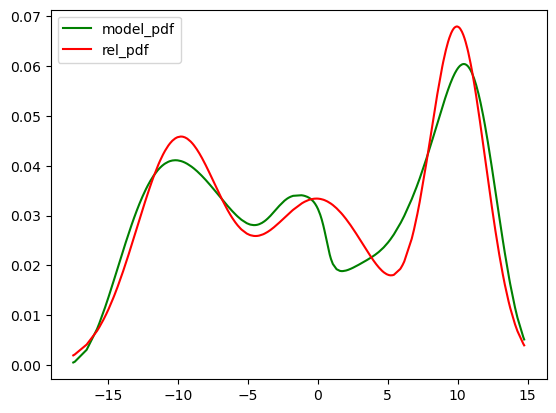

In [7]:
plt.close()
plt.subplot()
model_pdf = torch.concatenate([x,pdf],1)
# 获取第一列的值并对其进行排序
values, indices = model_pdf[:, 0].sort()
# 使用 index_select() 函数按行的顺序重新排列原始矩阵
model_pdf = torch.index_select(model_pdf, 0, indices)


rel_pdf = torch.concatenate([x,rel_pdf],1)
# 获取第一列的值并对其进行排序
values, indices = rel_pdf[:, 0].sort()
# 使用 index_select() 函数按行的顺序重新排列原始矩阵
rel_pdf = torch.index_select(rel_pdf, 0, indices)

plt.plot(*model_pdf.detach().numpy().T,color='g',label='model_pdf')
plt.plot(*rel_pdf.detach().numpy().T,color = 'r',label='rel_pdf')
plt.legend()


## 采样

(array([0.01347863, 0.03492193, 0.03553458, 0.02756993, 0.03737258,
        0.02879527, 0.01899262, 0.0422739 , 0.0459499 , 0.02879526]),
 array([-17.198353 , -14.010437 , -10.822522 ,  -7.6346064,  -4.4466906,
         -1.2587752,   1.9291403,   5.117056 ,   8.304972 ,  11.492887 ,
         14.680802 ], dtype=float32),
 <BarContainer object of 10 artists>)

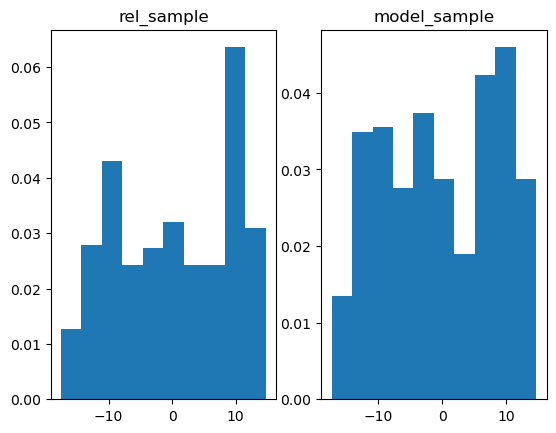

In [14]:
z_t0 = p_z0.sample([512]).to(device)
# plt.close()
# plt.hist(z_t0.cpu().numpy(),density=True)
z_t_samples, _ = odeint(
            func,
            (z_t0, logp_diff_t0),
                            torch.tensor([t0, t1]).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )
samples = z_t_samples[-1]
plt.close()
plt.subplot(1,2,1)
plt.title('rel_sample')
plt.hist(x.cpu().detach().numpy(),density=True)
plt.subplot(1,2,2)
plt.title('model_sample')
plt.hist(samples.cpu().detach().numpy(),density=True)